In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import nltk

In [2]:
df=pd.read_csv('../input/amazon-fine-food-reviews/Reviews.csv')

In [4]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
df.Text[0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [7]:
df=df.head(1000)

In [8]:
df.shape

(1000, 10)

Text(0, 0.5, 'Count')

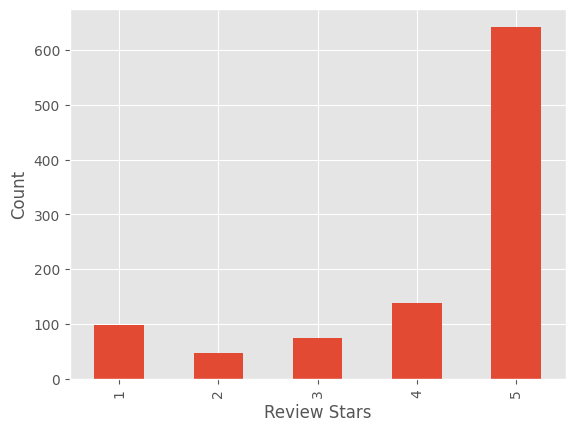

In [13]:
# EDA

ax=df.Score.value_counts().sort_index().plot(kind='bar')
ax.set_xlabel('Review Stars')
ax.set_ylabel('Count')

In [14]:
## Basic NLTK

In [16]:
eg=df.Text[50]
eg

"This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go."

In [18]:
tokens=nltk.word_tokenize(eg)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [20]:
tagged=nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [23]:
entities=nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


## 1. VADER Sentiment Scoring
Valence Aware Dictionary and sEntiment Reasoner

In [25]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia=SentimentIntensityAnalyzer()

In [26]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [27]:
sia.polarity_scores('This is the worst thing ever')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [28]:
sia.polarity_scores(eg)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [31]:
# Run the polarity score on the entire dataset

res={}
for i,row in tqdm(df.iterrows(), total=len(df)):
    text=row['Text']
    myid=row['Id']
    res[myid]=sia.polarity_scores(text)
    

  0%|          | 0/1000 [00:00<?, ?it/s]

In [38]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [39]:
vaders

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.079,0.853,0.068,-0.1027,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,0.026,0.721,0.253,0.9788,B006F2NYI2,A1D3F6UI1RTXO0,Swopes,1,1,5,1331856000,Hot & Flavorful,BLACK MARKET HOT SAUCE IS WONDERFUL.... My hus...
996,997,0.000,0.786,0.214,0.9309,B006F2NYI2,AF50D40Y85TV3,Mike A.,1,1,5,1328140800,Great Hot Sauce and people who run it!,"Man what can i say, this salsa is the bomb!! i..."
997,998,0.000,0.673,0.327,0.9634,B006F2NYI2,A3G313KLWDG3PW,kefka82,1,1,5,1324252800,this sauce is the shiznit,this sauce is so good with just about anything...
998,999,0.063,0.874,0.062,-0.0129,B006F2NYI2,A3NIDDT7E7JIFW,V. B. Brookshaw,1,2,1,1336089600,Not Hot,Not hot at all. Like the other low star review...


## Plotting vaders results

Text(0.5, 1.0, 'Compound Score by amazon star review')

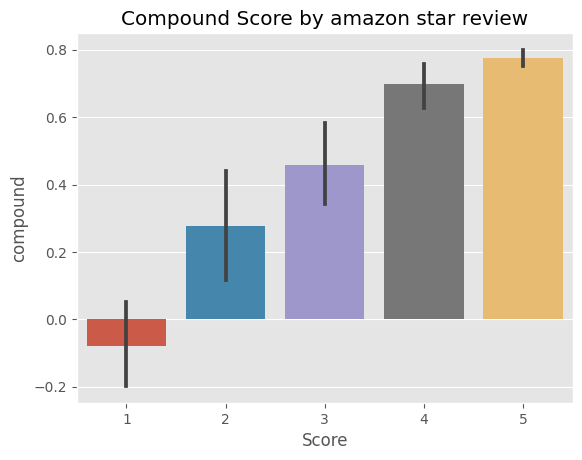

In [41]:
ax=sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compound Score by amazon star review')

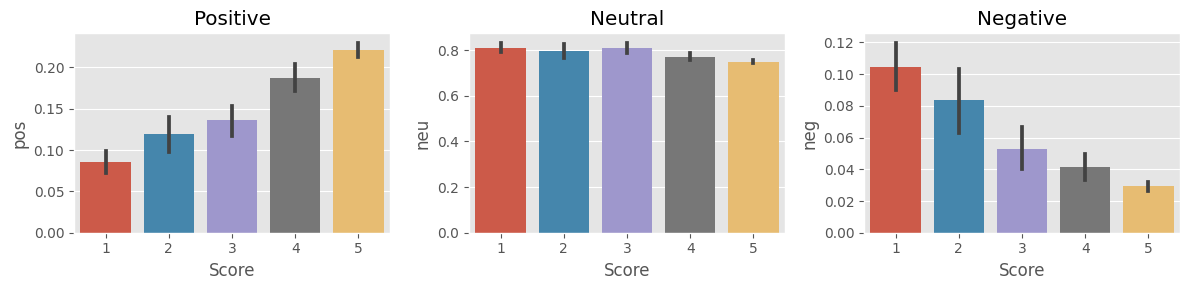

In [49]:
fig,axs=plt.subplots(1,3, figsize=(12,3))
sns.barplot(data=vaders, x='Score', y='pos',ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu',ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg',ax=axs[2])

axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

## Roberta Pretrained Model

In [51]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [52]:
MODEL=f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer=AutoTokenizer.from_pretrained(MODEL)
model=AutoModelForSequenceClassification.from_pretrained(MODEL)

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [54]:
print(eg)
sia.polarity_scores(eg)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [58]:
# Run for Roberta model
encoded_text=tokenizer(eg, return_tensors='pt')

In [64]:
output=model(**encoded_text)
output
# the output is a tensor

scores=output[0][0].detach().numpy()
scores=softmax(scores)

scores  #neg, neutral, pos

array([0.97635514, 0.02068747, 0.00295737], dtype=float32)

In [66]:
scores_dict={
    'roberta_neg':scores[0],
    'roberta_neu':scores[1],
    'roberta_pos':scores[2],
}

print(scores_dict)

{'roberta_neg': 0.97635514, 'roberta_neu': 0.020687466, 'roberta_pos': 0.0029573692}


In [71]:
def polarity_scores_roberta(ex):
    encoded_text=tokenizer(ex, return_tensors='pt')
    output=model(**encoded_text)
    scores=output[0][0].detach().numpy()
    scores=softmax(scores)

    scores_dict={
        'roberta_neg':scores[0],
        'roberta_neu':scores[1],
        'roberta_pos':scores[2],
    }
    return scores_dict


In [79]:
res2={}

for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text=row['Text']
        myid=row['Id']
        vader_res=sia.polarity_scores(text)
        vader_res_rename={}
    
        for key, value in vader_res.items():
            vader_res_rename[f'vader_{key}']=value
        roberta_res=polarity_scores_roberta(text)
        both={**vader_res,**roberta_res}  #combining 2 dict
        res2[myid]=both
    except RuntimeError:
        print(f'Broke for id{myid}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Broke for id83
Broke for id187
Broke for id529
Broke for id540
Broke for id746
Broke for id863


In [81]:
results_df=pd.DataFrame(res2).T
results_df=results_df.reset_index().rename(columns={'index':'Id'})
results_df=results_df.merge(df, how='left')

In [82]:
results_df

,Id,neg,neu,pos,compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.079,0.853,0.068,-0.1027,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,996,0.026,0.721,0.253,0.9788,0.001335,0.006112,0.992553,B006F2NYI2,A1D3F6UI1RTXO0,Swopes,1,1,5,1331856000,Hot & Flavorful,BLACK MARKET HOT SAUCE IS WONDERFUL.... My hus...
990,997,0.000,0.786,0.214,0.9309,0.002649,0.016077,0.981274,B006F2NYI2,AF50D40Y85TV3,Mike A.,1,1,5,1328140800,Great Hot Sauce and people who run it!,"Man what can i say, this salsa is the bomb!! i..."
991,998,0.000,0.673,0.327,0.9634,0.001362,0.011372,0.987266,B006F2NYI2,A3G313KLWDG3PW,kefka82,1,1,5,1324252800,this sauce is the shiznit,this sauce is so good with just about anything...
992,999,0.063,0.874,0.062,-0.0129,0.661606,0.293687,0.044707,B006F2NYI2,A3NIDDT7E7JIFW,V. B. Brookshaw,1,2,1,1336089600,Not Hot,Not hot at all. Like the other low star review...


## Compare Scores between the 2 models

In [83]:
results_df.columns

Index(['Id', 'neg', 'neu', 'pos', 'compound', 'roberta_neg', 'roberta_neu',
       'roberta_pos', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text'],
      dtype='object')

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

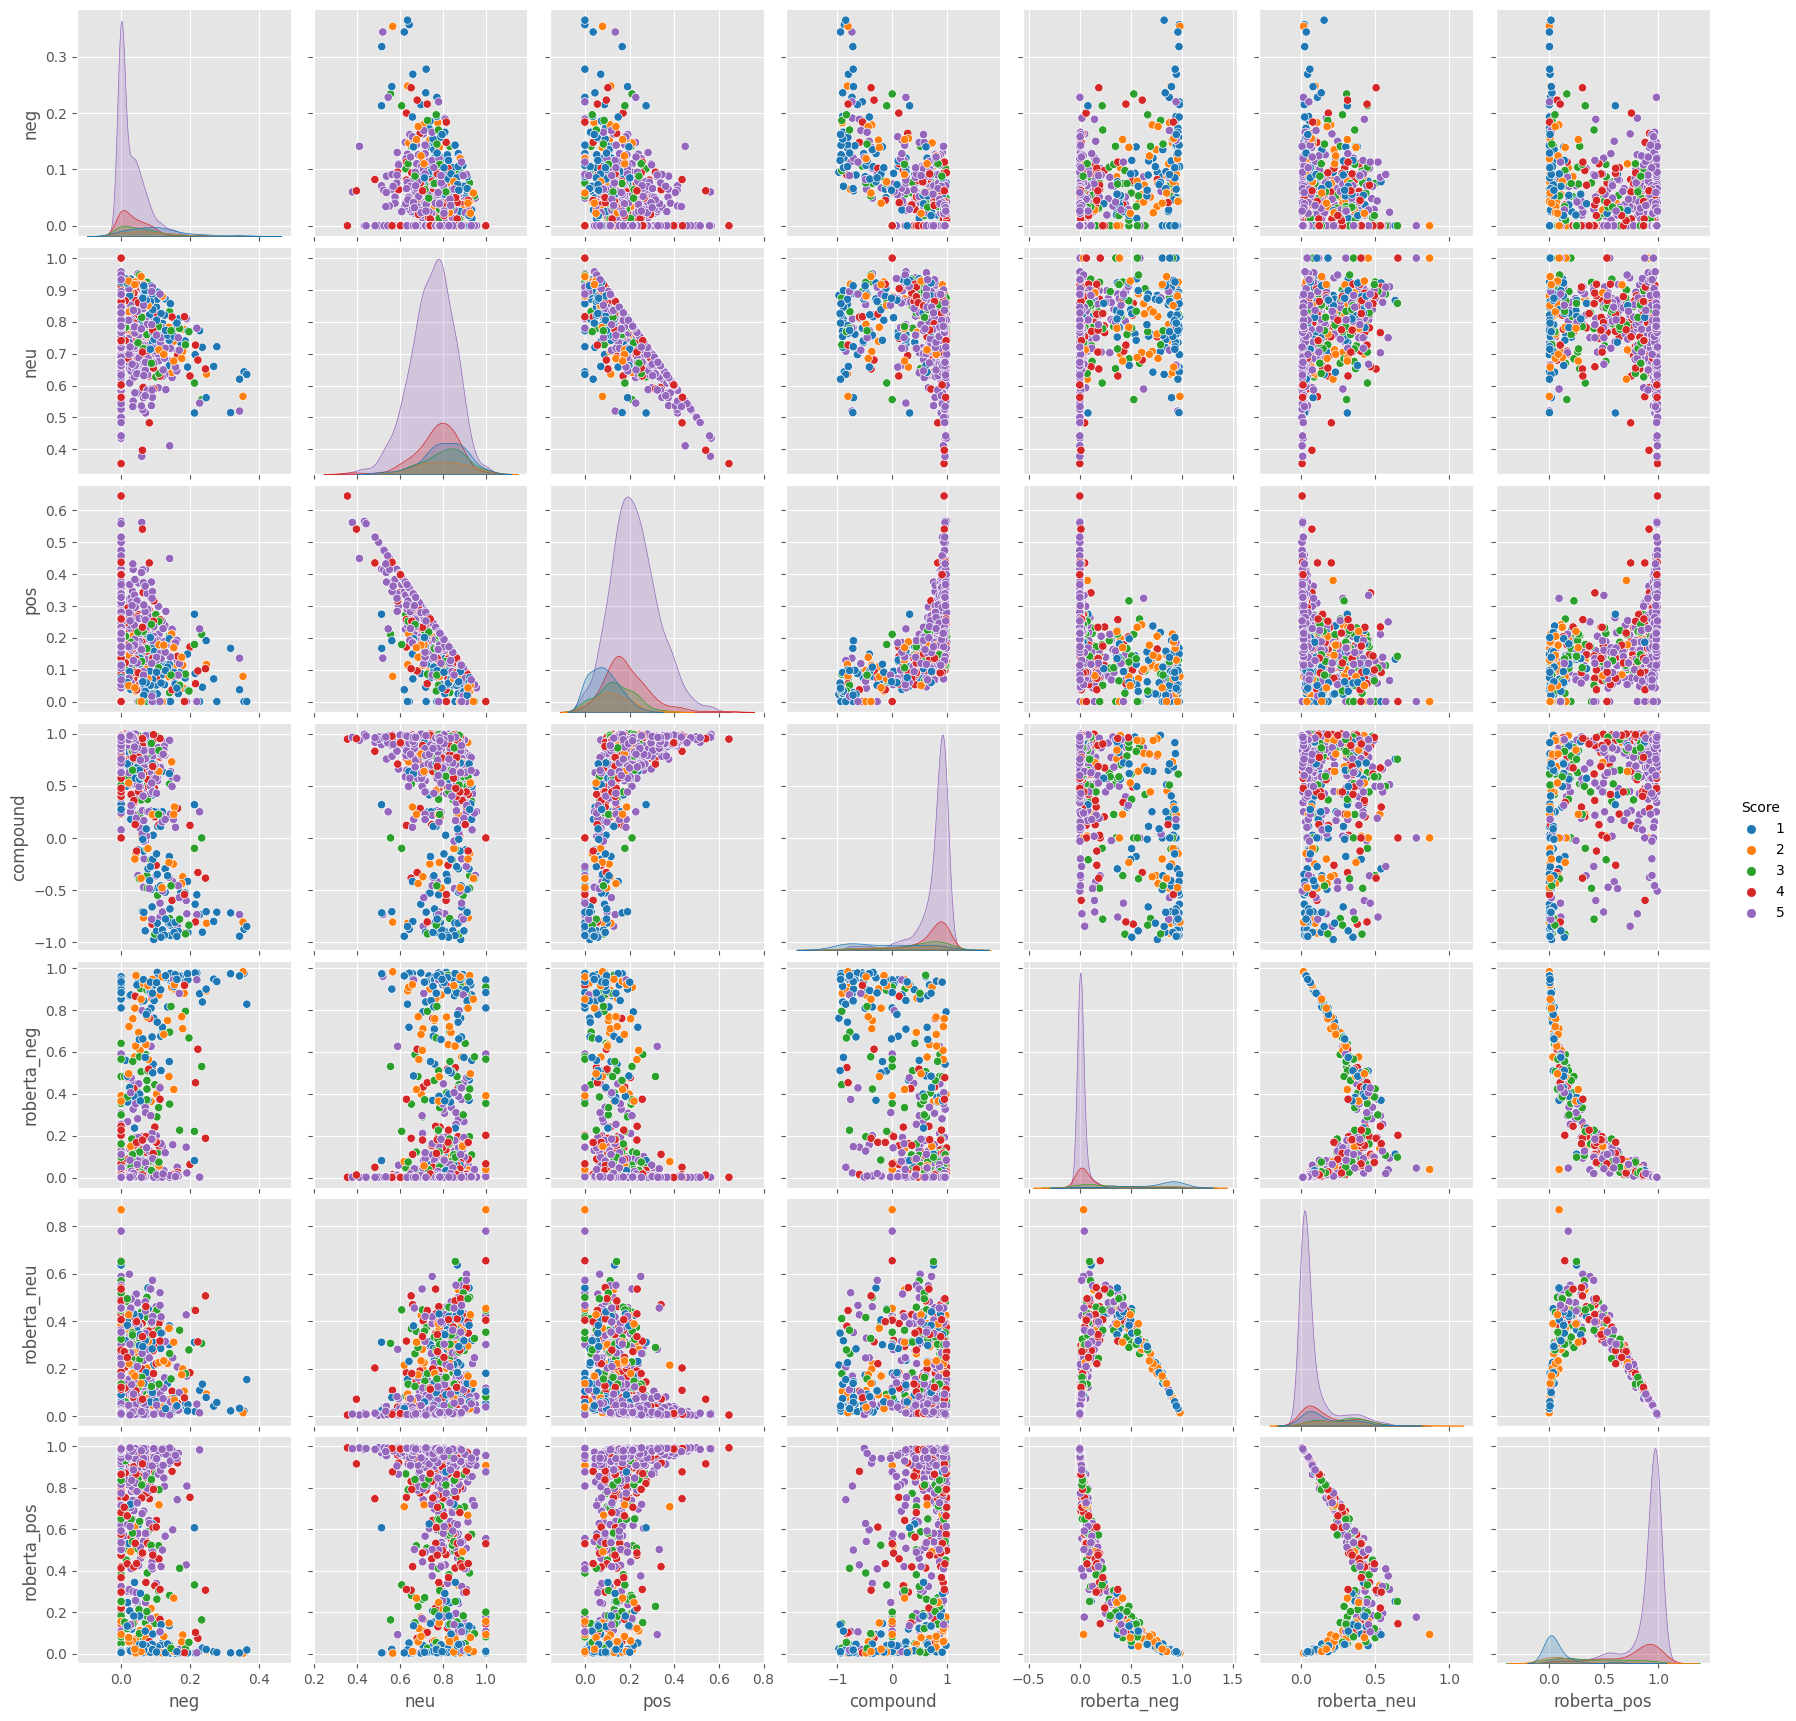

In [86]:
sns.pairplot(data=results_df, vars=['neg', 'neu', 'pos', 'compound', 'roberta_neg', 'roberta_neu',
           'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

## Review Examples

In [91]:
results_df.query('Score==1').sort_values('roberta_pos', ascending=False)['Text'].values[0]

"I just wanted to post here that I found small bits of plastic in this food as I was feeding my 9 month old.  Plastic!!! in food!!!! baby food!!!  So please be careful if you buy this or are considering it.<br /><br />My daughter LOVES this food-- it's actually her favorite.  This is the first time we have noticed plastic in it in over 2 months."

In [92]:
results_df.query('Score==1').sort_values('pos', ascending=False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [98]:
#negative sentiment 4 star review
results_df.query('Score==4').sort_values('roberta_neg', ascending=False)['Text'].values[0]

"I think Plocky's brand as a whole is a cut above in quality but I found these to lack in taste somewhat and be a little greasy."

In [102]:
#negative sentiment 4 star review with vader model
results_df.query('Score==4').sort_values('neg', ascending=False)['Text'].values[0]

'Eat at your own risk.  Once I would open a bag I could not stop.  Good and salty.'

In [109]:
from transformers import pipeline

In [105]:
sent_pipeline=pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [111]:

sent_pipeline('OH just get lost')

[{'label': 'NEGATIVE', 'score': 0.9992683529853821}]